In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib as mp

In [2]:
def vcf_clean(file):
    '''
    Input = Exported VCF from Geneious,
    Select columns ['Minimum', 'Maximum', 'Amino Acid Change', 'Change', 'Codon Change', 'locus_tag', 'Polymorphism Type', 'Protein Effect',
                    'Variant Frequency', 'Note'],
    Remove rows with 'Protein Effect' == NaN or None,
    Sort data by 'Variant Frequency' in descending order.
       
    Return cleaned VCF dataframe
    '''
    vcf = pd.read_csv(file, usecols = ['Minimum', 'Maximum', 'Change', 'locus_tag', 'Polymorphism Type',
                                       'Protein Effect', 'Variant Frequency', 'Amino Acid Change','Codon Change', 'note'])
    ## vcf = vcf[~vcf['Protein Effect'].isnull()].loc[vcf['Protein Effect'] != 'None'].loc[vcf['locus_tag'] != 'SCO3798']
    # Remove SNPs that caused no effect on protein encoding genes, but maintain all other intra/inter genetic changes
    vcf = vcf.loc[vcf['Protein Effect'] != 'None']
    # Clean the variant frequencies and pick up the floor of the range
    vcf['Variant Frequency']= list(map(lambda x: float(x[0].replace('%', ''))/100, vcf['Variant Frequency'].str.split( '->')))
    vcf.sort_values(by = ['Variant Frequency'], ascending = False, inplace = True)
    
    return vcf

In [95]:
def list_crosspop_mutation(wt_vcf, vf_threshold):
    ''' 
    Input = the wt_vcf dataframe from vcf_clean function, the threshold of Variant Frequency (e.g. 0.9)
    Keep the existed variances across the population with variant freq above threshold from time0 in our barcoded strain .
    Output = wt_vcf_crosspop
    '''
    wt_vcf_crosspop = wt_vcf.loc[wt_vcf['Variant Frequency'] >= vf_threshold]
    
    return wt_vcf_crosspop

In [4]:
def clean_WT(wt_vcf, vf_threshold):
    ''' 
    Input = the wt_vcf dataframe from vcf_clean function, the threshold of Variant Frequency
    Remove all rows with 'Variant Frequency' >= vf_threshold (e.g. 0.90) 
    so that the existed variances across the population from time0 in our barcoded strain are excluded from following analysis.
    Output = wt_vcf_new
    '''
    wt_vcf_new = wt_vcf.loc[wt_vcf['Variant Frequency'] < vf_threshold]
    
    return wt_vcf_new

In [96]:
def compare_to_wt(wt_vcf_new, wt_vcf, mutant_vcf):
    '''
    Input = the cleaned wt_vcf_new where variances across the population have been removed, 
            the wt_vcf including all variances
            the mutant_vcf cleaned by vcf_clean()
    Output = dataframe 'common' where common variances were found in both wt_vcf_new and the mutant_vcf,
             dataframe 'mutant_to_wt' where new variances were found only in mutant_vcf
    '''
    common = wt_vcf_new.merge(mutant_vcf, on = ['Minimum', 'Maximum', 'Change'])
    #mutant_to_wt = mutant_vcf[(~mutant_vcf['Minimum'].isin(common['Minimum'])) 
                              #& (~mutant_vcf['Maximum'].isin(common['Maximum'])) 
                              #& (~mutant_vcf['Change'].isin(common['Change']))]
    mutant_to_wt = mutant_vcf[(~mutant_vcf['Minimum'].isin(wt_vcf['Minimum'])) 
                              & (~mutant_vcf['Maximum'].isin(wt_vcf['Maximum'])) 
                              & (~mutant_vcf['Change'].isin(wt_vcf['Change']))]       
    mutant_to_wt['locus_tag'].fillna('intergenetic region', inplace = True)
    mutant_to_wt.set_index('locus_tag', inplace = True)
 
    
    # clean up the common df a bit by removing repeated columns
    common = common[['Minimum', 'Maximum', 'Change', 'locus_tag_x',
                    'Polymorphism Type_x', 'Protein Effect_x', 'Variant Frequency_x',
                    'Amino Acid Change_x', 'Codon Change_x', 'note_x', 'Variant Frequency_y']]
    common.rename(index=str, columns={'locus_tag_x':'locus_tag',"Polymorphism Type_x": "Polymorphism Type", "Protein Effect_x": "Protein Effect",
                                     'Variant Frequency_x': 'Variant Frequency WT', 'Amino Acid Change_x': 'Amino Acid Change',
                                     'Codon Change_x': 'Codon Change', 'note_x': 'note', 'Variant Frequency_y': 'Variant Frequency Mutant'}, inplace = True)
    common['locus_tag'].fillna('intergenetic region', inplace = True)
    common.set_index('locus_tag', inplace = True)
    
    return common, mutant_to_wt

In [98]:
files = glob.glob('G:\Dropbox (Vetsigian lab)\Vetsigian lab Team Folder\Ye\Genomics\M145 Evolved mutants\*.csv')

strain_names = list(map(lambda f: f.split('\\')[6].split('_')[0], files))
vcfs = list(map(lambda f: vcf_clean(f), files))
VCFs = dict(zip(strain_names, vcfs))
wt = VCFs['WT']
vf_threshold = 0.90
wt_new = clean_WT(wt, vf_threshold)

# Compare each mutant df in VCFs to the cleaned new WT vcf, wt_new. 
# This will generate a two layered dictionary where outside keys are the mutant names, 
# and the inside keys are "common" and "variance" that corresponding to the variance shared by wt and mutants 
# and to the variance found only in mutants respectively.

mutant_names = strain_names[:-1]
dict_mutants_to_wt = {}
for name in mutant_names:
    [common, variance]= compare_to_wt(wt_new, wt, VCFs[name])
    dict_mutants_to_wt[name] = {}
    dict_mutants_to_wt[name]['common'] = common
    dict_mutants_to_wt[name]['variance'] = variance
wt_new['locus_tag'].fillna('intergenetic region', inplace = True)
wt_new.set_index('locus_tag', inplace = True)

C:\Users\yxu\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [100]:
dict_mutants_to_wt['W1']['variance']


,Minimum,Maximum,Change,Polymorphism Type,Protein Effect,Variant Frequency,Amino Acid Change,Codon Change,note
locus_tag,,,,,,,,,
SCO3074,3368076,3368077,CC -> TT,Substitution,Substitution,1.000,QD -> QN,"CAG,GAC -> CAA,AAC","SCE25.15c, possible integral membrane protein,..."
intergenetic region,1110680,1110679,(C)4 -> (C)5,Insertion (tandem repeat),NaN,0.952,NaN,NaN,NaN
intergenetic region,4171257,4171260,GGCA -> ACTC,Substitution,NaN,0.529,NaN,NaN,NaN
intergenetic region,4171243,4171248,GGAGGC -> CCCCAA,Substitution,NaN,0.469,NaN,NaN,NaN
intergenetic region,4171268,4171269,CT -> AC,Substitution,NaN,0.353,NaN,NaN,NaN
intergenetic region,4171231,4171233,GCT -> CGA,Substitution,NaN,0.303,NaN,NaN,NaN
SCO3798,4178705,4178706,GT -> CC,Substitution,Substitution,0.303,H -> R,CAC -> CGG,"SCAC2.06c, possible chromosome condensation pr..."
SCO3792,4171226,4171227,AA -> GT,Substitution,Extension,0.294,NaN,NaN,methionine--tRNA ligase; MetRS; adds methionin...
intergenetic region,4171240,4171240,-A,Deletion,NaN,0.294,NaN,NaN,NaN


In [101]:
# Compare variance frequencies of mutatations shared by wt and mutants ('the common data set and wt data set')
common_vf_comp = {}
for mutant in mutant_names:
    common_vf_comp[mutant] = dict_mutants_to_wt[mutant]['common'][['Variant Frequency WT', 'Variant Frequency Mutant', 'note']]
    

common_var_df = dict_mutants_to_wt['R1']['common']
lab1 = common_var_df.index.values
lab2 = common_var_df['Change']
lab_list = list(zip(lab1, lab2))
tuple(map(lambda tup: tup[0] + ',' + tup[1], lab_list))

('SCO3798,G -> A',
 'SCO3798,CGTG -> GTAA',
 'SCO3736,G -> A',
 'SCO3798,CCCGG -> TCTCA',
 'SCO3798,CGC -> TTG',
 'SCO5693,G -> C',
 'SCO3736,G -> C')

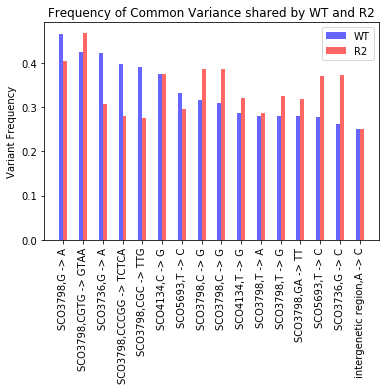

In [102]:
# Build a bar plot to see the common variance change from wt to each mutant
import matplotlib.pyplot as plt

def barplot_common_variance(dict_mutants_to_wt, mutant_name, bar_width, opacity, xtick_rot):
    common_var_df = dict_mutants_to_wt[mutant_name]['common']
    n_group = len(common_var_df.index.values)
    vf_wt = common_var_df['Variant Frequency WT']
    vf_mutant = common_var_df['Variant Frequency Mutant']
    fig, ax = plt.subplots()
    index = np.arange(n_group)
    rects1 = ax.bar(index, vf_wt, bar_width,
                alpha=opacity, color='b', label='WT')
    rects2 = ax.bar(index + bar_width, vf_mutant, bar_width,
                alpha=opacity, color='r', label= mutant_name)
    ax.set_ylabel('Variant Frequency')
    ax.set_title('Frequency of Common Variance shared by WT and ' + mutant_name)
    ax.set_xticks(index + bar_width / 2)
    xticklab1 = common_var_df.index.values 
    xticklab2 = common_var_df['Change']
    lab_list = list(zip(xticklab1, xticklab2))
    xticklab = tuple(map(lambda tup: tup[0] + ',' + tup[1], lab_list))    
    ax.set_xticklabels(xticklab, rotation = xtick_rot)
    ax.legend()
    plt.show()

barplot_common_variance(dict_mutants_to_wt, 'R2', 0.2, 0.6, 90)   

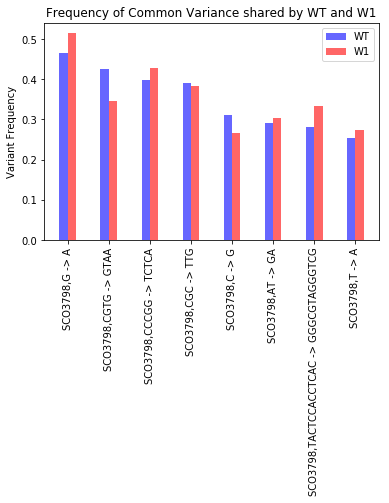

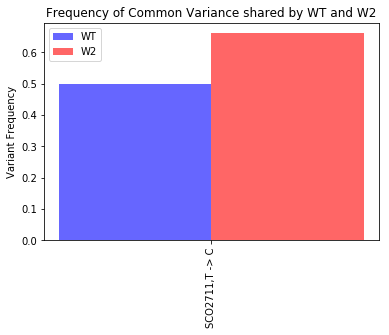

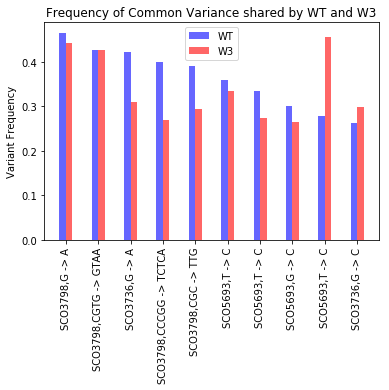

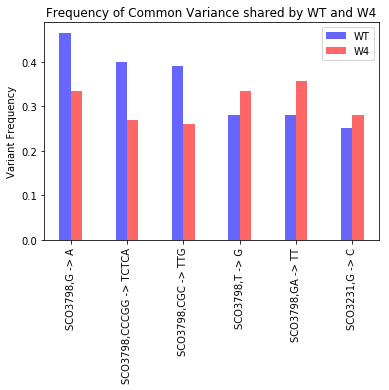

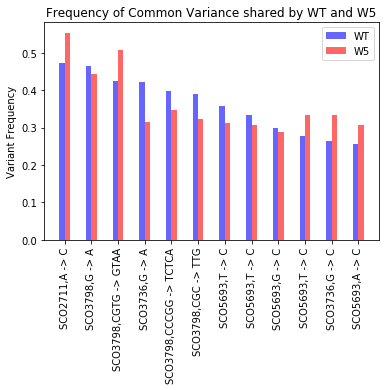

In [103]:
# Barplot the variant frequency by mutant group: R (R1 to R5), RH (RH1 to RH5), W(W1 to W5), WS(WS1 and WS2)

# Group the mutants into their phenotypic group
mutant_group = {'R': list(), 'RH':list(), 'W': list(), 'WS': list()}
for key in dict_mutants_to_wt.keys():
    group_name = ''.join([i for i in key if not i.isdigit()])
    if group_name in mutant_group.keys():
        mutant_group[group_name]. append(key)

mutant_names = mutant_group['W']  
for mut in mutant_names:
    barplot_common_variance(dict_mutants_to_wt, mut, 0.2, 0.6, 90)

    

In [115]:
# find novel mutations only found in the mutants with variant freq > 0.5

def find_locus(dict_mutants_to_wt, variant_freq, mutant_name):
    mutant2wt = dict_mutants_to_wt[mutant_name]['variance']
    return mutant2wt[mutant2wt['Variant Frequency'] > variant_freq][['Change', 'note']]
    
variant_freq = 0.5
mutation_genes = {}
for name in dict_mutants_to_wt.keys():
    mutation_genes[name] = find_locus(dict_mutants_to_wt, variant_freq, name)
mutation_genes['W4']
 
#df = pd.DataFrame.from_dict(mutation_genes, orient="index")
#df.to_csv("G:\\Ye\\Evolution mutants\\mutation_genes.csv")

,Change,note
locus_tag,,
intergenetic region,-ACGGGGC,NaN
SCO6167,TGGT -> CCCC,"SC6C5.03, proline rich protein (membrane prote..."
SCO6167,GT -> CC,"SC6C5.03, proline rich protein (membrane prote..."
intergenetic region,GA -> CC,NaN


['R1',
 'R2',
 'R3',
 'R4',
 'R5',
 'RH1',
 'RH2',
 'RH5',
 'W1',
 'W2',
 'W3',
 'W4',
 'W5',
 'WS1',
 'WS2']